# Benchmark to find threshold for filtering low-variance features

See https://git.bia-christian.de/bia/lab_book_VEO/wiki/feature-selection#remove-low-variance-features

In [61]:
#Turn off scientific notation
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import numpy as np
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format})

#Activate print all activities
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Import input

In [62]:
import pickle
import zstandard
import pandas as pd
import numpy as np
import datetime

print("Started script! Loading input file...", datetime.datetime.now())

#feature = 'kmer9Classification'
#feature = 'kmer9Regression'
feature = 'gene-familiesClassification'
#feature = 'gene-familiesRegression'
#feature = 'gene-families'
#feature = 'kmer9'

abiotic_factor = 'salt'
#abiotic_factor = 'temperature'
#abiotic_factor = 'pH'
#abiotic_factor = 'oxygen'

group = 'Salinity group'
#group = 'Salt all mean'
#group = 'Temp group'
#group = 'Temp all mean'
#group = 'pH all mean'
#group = 'Oxygen tolerance'

file1 = '/home/bia/Documents/bacterial_phenotypes/connecting_features_abFactors/df_' + abiotic_factor + '_' + feature + '_selected-filterNA.pickle.zst'  

with zstandard.open(file1, 'rb') as f:
	df = pickle.load(f)

print("Loaded input pickle zst file...", datetime.datetime.now())
df.head()
df.shape

Started script! Loading input file... 2024-07-15 09:55:49.187736
Loaded input pickle zst file... 2024-07-15 09:55:49.341187


,COG3696@2,COG0606@2,33SZW@2,COG0774@1,COG5009@2,COG0188@2,COG0265@2,COG3270@1,2Z7XP@2,COG1086@2,...,arCOG06650@2157,"Viruses,4R0IQ@35237",arCOG09713@2157,arCOG07735@2157,arCOG07334@2157,arCOG04203@2157,arCOG01811@2157,arCOG00087@2157,arCOG07496@2157,Salinity group
Best assembly,,,,,,,,,,,,,,,,,,,,,
1121349.4,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium
1121909.4,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,high
1123508.3,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,low
1218801.3,1,1,0,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,medium
1420583.3,1,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium


(3418, 20142)

# Understand the variances of the features

# SKIP to next block

In [95]:
#Investigate the variance distribution of the current feature type

print("Shape of the input dataframe:", df.shape)
print()

#Separating features from group/target variable
X = df.drop(group, axis=1)
y = df[group]

#Calculate variance for each feature/column of all features
variances = X.var()

df_var = variances.to_frame()
df_var = df_var.rename(columns={0: 'Variance'})

# Normalize column of variances
df_var['Normalized variance'] = (df_var['Variance'] - df_var['Variance'].min()) / (df_var['Variance'].max() - df_var['Variance'].min())

df_var.head()

#Normalized Data
#normalized = (x-min(x))/(max(x)-min(x))

#type(df_var)
len(df_var)
#df_var.head()

df_var['Variance'].min()
df_var['Variance'].max() #Max could come from the abiotic factor!
df_var['Variance'].mean()
df_var['Variance'].median()

df_var['Normalized variance'].min()
df_var['Normalized variance'].max() #Max could come from the abiotic factor!
df_var['Normalized variance'].mean()
df_var['Normalized variance'].median()

#df['COG5009@2'].value_counts() #0.25
#df['33SZW@2'].value_counts() #0
#df['COG0480@2'].value_counts() #0.3

Shape of the input dataframe: (3418, 131073)



,Variance,Normalized variance
AAAAAAAAA,14786.90,0.01
AAAAAAAAC,11790.81,0.01
AAAAAAAAG,12331.79,0.01
AAAAAAAAT,47927.40,0.03
AAAAAAACA,31560.68,0.02


131072

4.330803645353585

1420161.019059951

3287.276805587188

519.1688780138136

0.0

1.0

0.0023116787246713574

0.00036252202213023937

In [85]:
#Only for the very first abiotic factor!
#df_all = df_var
#df_all = df_all.drop(columns=['Variance'])
#df_all = df_all.rename(columns={'Normalized variance': abiotic_factor})

#df_all.head()

,oxygen
AAAAAAAAA,0.01
AAAAAAAAC,0.01
AAAAAAAAG,0.01
AAAAAAAAT,0.04
AAAAAAACA,0.02


In [96]:
df_var = df_var.rename(columns={'Normalized variance': abiotic_factor})
df_all[abiotic_factor] = df_var[abiotic_factor]
df_all.head()

,oxygen,pH,temperature,salt
AAAAAAAAA,0.01,0.01,0.01,0.01
AAAAAAAAC,0.01,0.01,0.01,0.01
AAAAAAAAG,0.01,0.01,0.01,0.01
AAAAAAAAT,0.04,0.03,0.02,0.03
AAAAAAACA,0.02,0.02,0.01,0.02


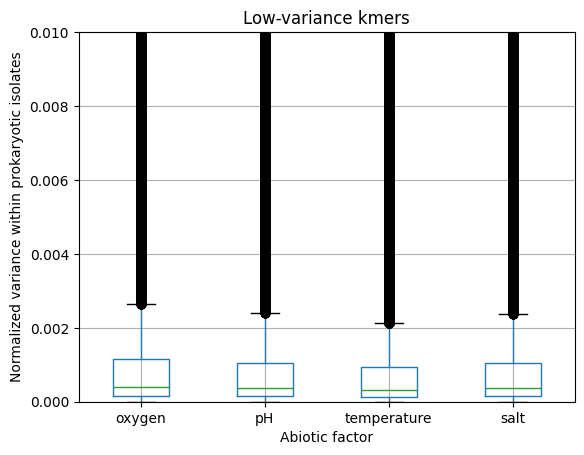

In [97]:
from matplotlib.ticker import ScalarFormatter

#Plot variance distribution

boxplot = df_all.boxplot()

#https://www.reddit.com/r/learnpython/comments/el4vbx/how_to_remove_scientific_notation_from_a/
#Remove scientific notation from y-axis
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

#Add axis labels and title
plt.xlabel('Abiotic factor');
#plt.ylabel('F1 scores');
plt.ylabel('Normalized variance within prokaryotic isolates');
#plt.title('Impact of low-variance filtering in F1 scores');
plt.title('Low-variance kmers');

# Set y-axis limits
plt.ylim(0, 0.01), 

#plt.savefig('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/boxplot_variances_gene-families.png', dpi=300)
plt.savefig('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/boxplot_variances_kmer9.png', dpi=300)

# Show the plot
plt.show();

# Create files for filtering low-variance features with different thresholds

In [63]:
#CLASSIFICATION #########################################
#STEP NECESSARY BEFORE CREATING FILES ###################

df[group].unique()

#Oxygen
#Replace string to int for target variable
#df[group] = df[group].replace(['anaerobe'], 0)
#df[group] = df[group].replace(['facultative'], 2)
#df[group] = df[group].replace(['aerobe'], 1)

#Salt, temperature
#Replace string to int for target variable
df[group] = df[group].replace(['low'], 0)
df[group] = df[group].replace(['medium'], 2)
df[group] = df[group].replace(['high'], 1)

#MAKE SURE THE NUMBER OF GROUPS IS CORRECT AND ADAPT CODE IF NECESSARY
print('Number of isolates with group low/anaerobe:', len(df[df[group] == 0]) )
print('Number of isolates with group medium/facultative:', len(df[df[group] == 2]) )
print('Number of isolates with group high:/aerobe', len(df[df[group] == 1]) )

array(['medium', 'high', 'low'], dtype=object)

/tmp/ipykernel_3335/2217828683.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[group] = df[group].replace(['high'], 1)


Number of isolates with group low/anaerobe: 466
Number of isolates with group medium/facultative: 1429
Number of isolates with group high:/aerobe 1523


In [64]:
#Change range for loop for kmers or gene-families
#For classification, remove group == 2 below!
#For kmers, change i = round(i, 3) to     i = round(i, 4)

#Create files with different thresholds

print("Shape of the input dataframe:", df.shape)
print()

#Separating features from group/target variable
X = df.drop(group, axis=1)
y = df[group]

#Calculate variance for each feature/column of all features
variances = X.var()

# Normalize column of variances
variances = ( variances - variances.min()) / (variances.max() - variances.min() )


#Initialize list of percentages of low-variance features to be filtered out
values = []        

#Identify columns with different variances
for i in np.arange(0, 0.011, 0.001):
#for i in np.arange(0, 0.0021, 0.0001):
    
    tmp = X.copy()

    #Get list of columns with variance smaller or equal to i
    zero_variance_columns = variances[variances <= i].index
    #print(zero_variance_columns)

    #Add to list the percentage of low-variance features to be filtered out
    percentage = str( round( (len(zero_variance_columns)/len(tmp.columns))*100, 1) )
    values.append(percentage)
    
    print(" Threshold:", i, "Number of zero-variance features:", len(zero_variance_columns), ',', percentage)

    #Drop low-variance features
    tmp = tmp.drop(columns=zero_variance_columns)

    tmp[group] = y
    
    #Remove intermediate group to keep only extremes for benchmarking below
    #NOTE THAT THE LOW-VARIANCE FEATURES WERE REMOVED BEFORE REMOVING INTERMEDIATE GROUP!
    #Removal of the intermediate group is only done for benchmarking reasons!
    tmp = tmp[tmp[group] != 2]
    
    #tmp.head()

    print(" Shape of dataframe without zero-variance features:", tmp.shape, " Any NAs in the dataframe?", tmp.isnull().any().any())
    
    with zstandard.open('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_' + abiotic_factor + '_' + feature + '_' + str(i) + '.pickle.zst', 'wb') as f:
        pickle.dump(tmp, f)

Shape of the input dataframe: (3418, 20142)

 Threshold: 0.0 Number of zero-variance features: 9155 , 45.5
 Shape of dataframe without zero-variance features: (1989, 10987)  Any NAs in the dataframe? False
 Threshold: 0.001 Number of zero-variance features: 9155 , 45.5
 Shape of dataframe without zero-variance features: (1989, 10987)  Any NAs in the dataframe? False
 Threshold: 0.002 Number of zero-variance features: 12755 , 63.3
 Shape of dataframe without zero-variance features: (1989, 7387)  Any NAs in the dataframe? False
 Threshold: 0.003 Number of zero-variance features: 14199 , 70.5
 Shape of dataframe without zero-variance features: (1989, 5943)  Any NAs in the dataframe? False
 Threshold: 0.004 Number of zero-variance features: 15036 , 74.7
 Shape of dataframe without zero-variance features: (1989, 5106)  Any NAs in the dataframe? False
 Threshold: 0.005 Number of zero-variance features: 15520 , 77.1
 Shape of dataframe without zero-variance features: (1989, 4622)  Any NAs in 

## Benchmark

In [65]:
#Importing packages
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sys

In [66]:
#REGRESSION #########################################

#See remove_zero_variance_py

In [67]:
#CLASSIFICATION #########################################
#CHANGE LINE BELOW  TO FIT GENE FAMILIES OR KMERS

#Benchmark different thresholds of filtering low-variance features

#Cross-validation packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import statistics
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

f1_df = pd.DataFrame()

path = '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_'

#Loop for different thresholds for filtering low-variance
for i in np.arange(0, 0.011, 0.001):  
#for i in np.arange(0, 1100, 100):
        
    with zstandard.open(path + abiotic_factor + '_' + 
                        feature + '_' + str(i) + '.pickle.zst', 'rb') as f: 
        tmp = pickle.load(f)
    
    print('Calculating metrics for threshold', i, 'of filtering low-variance features...')
    print('  Shape of input data:', tmp.shape)
    
    list_means = []

    #Separating features from group/target variable
    X = tmp.drop(group, axis=1)
    y = tmp[group]

    #I included random_state to make this command reproducible for after feature selection
    #Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle=True, random_state = 99)
    
    #UNDERSAMPLING - important for classification problems and unbalanced groups
    #Definindo o RandomUnderSampler
    #I used a seed for the random state, which means that the undersampling will always choose the same samples,
    # which in my case is fine, since I am comparing different thresholds
    rus = RandomUnderSampler(random_state=5)
    
    # Aplicando para X e y
    X, y = rus.fit_resample(X_train, y_train)
    print('  Shape of training and undersampled data:', X.shape)
    
    #Do 10 iterations for every different threshold
    for it in range(1, 11, 1):
#    for it in range(1, 3, 1):        

        #Cross-validation with seed that changes with every iteration. The same split is desired per thresholds, since I want to
        # compare them. However within iterations, I want different splits
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=it)
        #I ran salt, gene-families without seed, and the results were extremely similar
    
        #Instantiate Random Forest model
        clf = RandomForestClassifier()

        scoring = ['f1']
        output = cross_validate(clf, X, y, cv=5, scoring = scoring, return_train_score=False, return_estimator =True)
        #print(output)
        #{'fit_time': array([0.68, 0.73, 0.72, 0.68, 0.61]), 'score_time': array([0.12, 0.11, 0.11, 0.19, 0.11]), 
        #'estimator': [RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier()], 
        #'test_f1': array([0.91, 0.90, 0.88, 0.75, 0.68])}
        
        #Get mean F1 for this iteration
        mean = statistics.mean(output['test_f1'])
        #Add mean F1 to vector containing results of all iterations
        list_means.append(mean)

        print(' Iteration', it, 'has as mean F1 value =', round(mean, 3), 'All values:', output['test_f1'])
    
    print(' Mean F1 score of cross-validation for all iterations:', round(statistics.mean(list_means), 3))

    #Add new values
    f1_df[i] = list_means

#Save benchmark results to a CSV file
#f1_df.to_csv(path + 'f1_benchmark_' + abiotic_factor + '_' + feature + '.csv', index=True)

Calculating metrics for threshold 0.0 of filtering low-variance features...
  Shape of input data: (1989, 10987)
  Shape of training and undersampled data: (746, 10986)
 Iteration 1 has as mean F1 value = 0.861 All values: [0.87 0.86 0.85 0.88 0.85]
 Iteration 2 has as mean F1 value = 0.853 All values: [0.89 0.82 0.87 0.85 0.84]
 Iteration 3 has as mean F1 value = 0.85 All values: [0.86 0.82 0.85 0.85 0.86]
 Iteration 4 has as mean F1 value = 0.862 All values: [0.90 0.83 0.86 0.86 0.87]
 Iteration 5 has as mean F1 value = 0.854 All values: [0.84 0.83 0.83 0.90 0.86]
 Iteration 6 has as mean F1 value = 0.86 All values: [0.86 0.85 0.86 0.85 0.87]
 Iteration 7 has as mean F1 value = 0.833 All values: [0.84 0.82 0.82 0.88 0.81]
 Iteration 8 has as mean F1 value = 0.856 All values: [0.88 0.86 0.85 0.84 0.86]
 Iteration 9 has as mean F1 value = 0.86 All values: [0.87 0.84 0.86 0.86 0.86]
 Iteration 10 has as mean F1 value = 0.851 All values: [0.87 0.82 0.85 0.85 0.85]
 Mean F1 score of cross

KeyboardInterrupt: 

In [159]:
f1_df

#Save benchmark results to a CSV file
f1_df.to_csv(path + 'f1_benchmark_' + abiotic_factor + '_' + feature + '.csv', index=True)

,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.01
0,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97
1,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97
2,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97
3,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97
4,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97
5,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97
6,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97
7,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97
8,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97
9,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97


# Plot

In [68]:
import pandas as pd

# Load CSV data into a DataFrame
f1_df = pd.read_csv('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_f1_benchmark_'  + abiotic_factor + '_' + feature +  '.csv', index_col = 0)
f1_df.head()

,0.0,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009000000000000001,0.01
0,0.86,0.86,0.84,0.85,0.85,0.84,0.86,0.87,0.87,0.86,0.84
1,0.86,0.86,0.84,0.85,0.85,0.86,0.85,0.85,0.86,0.87,0.85
2,0.86,0.85,0.86,0.84,0.86,0.85,0.86,0.85,0.85,0.88,0.85
3,0.85,0.85,0.85,0.85,0.85,0.85,0.84,0.86,0.86,0.86,0.87
4,0.85,0.84,0.86,0.85,0.86,0.86,0.86,0.86,0.86,0.86,0.85


In [69]:
f1_df.columns
#f1_df = f1_df.rename(columns={0.001: 0.009})
f1_df = f1_df.rename(columns={'0.009000000000000001': '0.009'})
f1_df.columns

Index(['0.0', '0.001', '0.002', '0.003', '0.004', '0.005', '0.006', '0.007',
       '0.008', '0.009000000000000001', '0.01'],
      dtype='object')

Index(['0.0', '0.001', '0.002', '0.003', '0.004', '0.005', '0.006', '0.007',
       '0.008', '0.009', '0.01'],
      dtype='object')

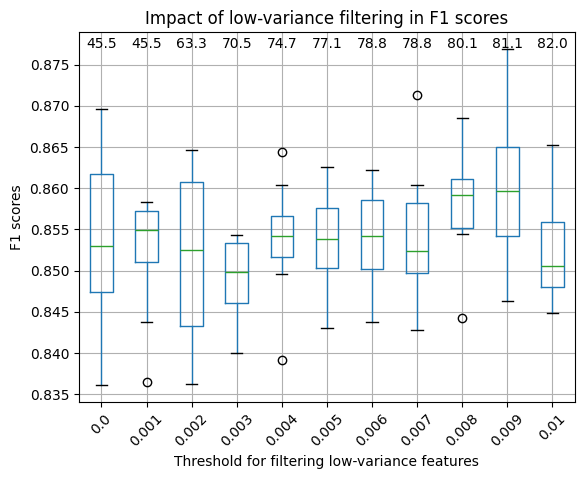

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

#Plot results 

#ADAPT THE LABELS FOR REGRESSION/CLASSIFICATION
#Plot the metrics for the cross-validation

boxplot = f1_df.boxplot();

#values is a list of percentages of low-variance features to be filtered out
labels = values#[0:6]
n_cols = len(labels)
#Height on y-axis where the lables/values should be displayed
draw_at = 0.877
for x, y, l in zip(range(1,n_cols+1), np.repeat(draw_at, n_cols),
labels):
    boxplot.text(x, y, l, horizontalalignment='center')

#Add axis labels and title
plt.xlabel('Threshold for filtering low-variance features');

plt.ylabel('F1 scores');
#plt.ylabel('Mean Absolute Error (MAE)');
plt.title('Impact of low-variance filtering in F1 scores');
#plt.title('Impact of low-variance filtering in MAEs');

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)
ticks = plt.xticks()[0]
labels = [str(round(float(label), 1)) for label in ticks]  # Round each label to 3 decimal places

plt.savefig('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/benchmark_' + abiotic_factor + '_' + feature + '.png', dpi=300)

#Show plot
plt.show();